# <b>ICE Community Resistance: When, Where, and What</b>


### <b>Arrests by Time of Day</b>

<i>to know when the bastards are most active</i>

In [1]:
import numpy as np
import pandas as pd
import warnings, datetime
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import cm
from scipy.interpolate import interp1d

#suppressing mixed dtypes, null vals in years without data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arrests_original = pd.read_csv("/home/betel/Desktop/Spring '26/Notes/ICE/DD Proj Files/Arrests 2011-2025 (clean).csv")
arrests_original = arrests_original.drop("Unnamed: 0", axis=1)

pd.options.mode.chained_assignment = None  # default = 'Warn', changed because we don't care about manipulating copies here

In [2]:
arrests_tod = arrests_original[arrests_original["Has Time Of Day"]]

<AxesSubplot: title={'center': 'The Wretched Porcupine'}, xlabel='Time'>

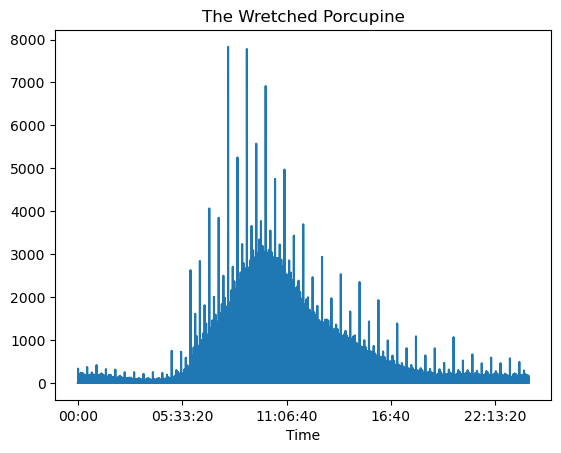

In [3]:
arrests_tod["Time"] = pd.to_datetime(arrests_tod["Apprehension Date Time"]).sort_index()
arrests_tod.Time.apply(lambda x : x.time()).value_counts().sort_index().plot.line(title="The Wretched Porcupine");

### This is a highly naiive implementation
<i> Unfortunately, as many officers enter rounded timestamps to the nearest hour, halfhour, or fifteen minutes (visible in the variously sized spikes in this chart), we don't really have a pretty organiation. This would easily demonstrates more active times, but instead of spending time beautifying this tiny thing, we'll group the data first for readibility. </i>

To do this, we'll round all timestamps to the nearest halfhour:

In [4]:
#some helper funcs

#round a datetime to nearest halfhour, preserving date info
def round_halfhour(t):
    delta = timedelta(minutes=30)
    return (t + delta // 2) - timedelta(minutes=t.minute % 30-15, seconds=t.second, microseconds=t.microsecond)

#WILDLY slow, like oh my god this is so slow, but this is what you get for doing rounding operations on multiple millions
#takes DF with col "Time" of datetimes
def get_clean_tod(tod):
    return tod.Time.map(round_halfhour).apply(lambda x : x.time()).value_counts().sort_index()

#plot heatmap bar graph. takes DF with col "Time" of datetimes & name of graph
def tod_heatmap(tod, name):
    tod = get_clean_tod(tod) #clean up inputs
    
    #map values to colours
    m = interp1d([tod.min(),tod.max()],[0,255])
    colours = cm.viridis(tod.map(m).astype(int))

    #the plot :3
    return tod.plot.bar(figsize=(10, 4), ylabel='Number of Arrests', rot = 45, color=colours, title=name).locator_params(axis='x', nbins=24)

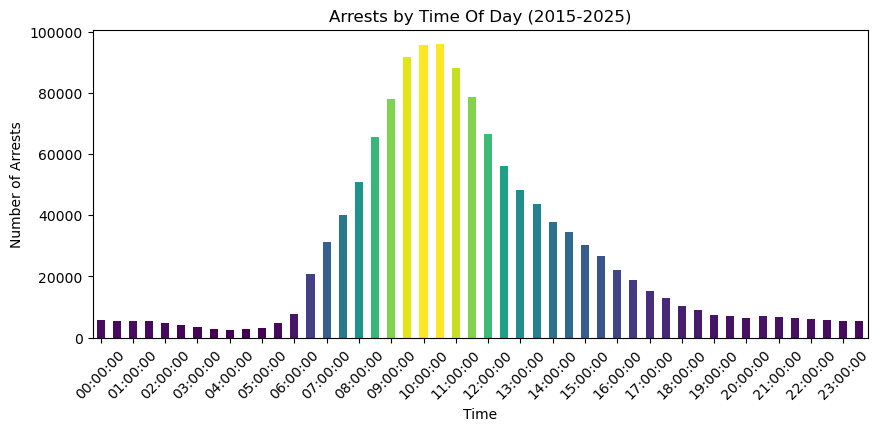

In [5]:
#2015 as no ToD vals exist before then
tod_heatmap(arrests_tod, "Arrests by Time Of Day (2015-2025)")

### Let's double-check that this still holds for recent ICE activity

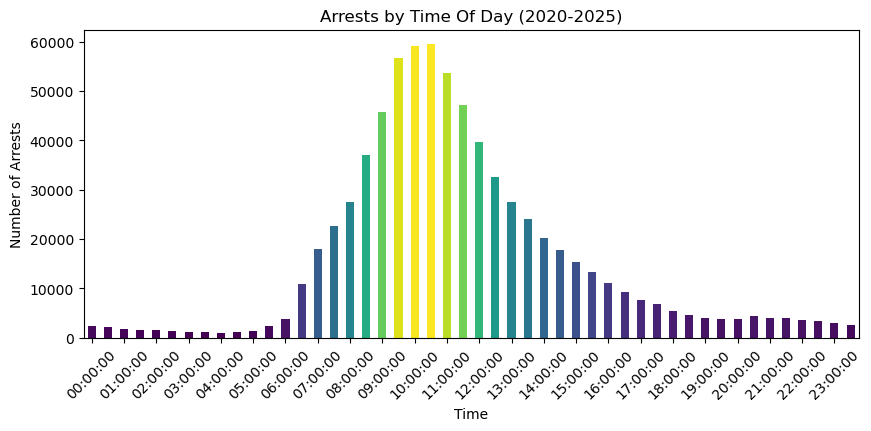

In [6]:
#all arrests with ToD post 2020
post_2020 = arrests_tod[datetime.datetime(2020, 1, 1) < arrests_tod.Time]
tod_heatmap(post_2020, "Arrests by Time Of Day (2020-2025)")

<i> So we can see clearly now that between 9am-11am is peak ICE activity, dropping off after noon slowly. Activity is consistently very low after 6pm, and picks up around 7am.</i>

<b> This would suggest that community-defense efforts (ICE watches, among other things) should focus their efforts during the late mornings moreso than any other time of day, though ICE activity remains high until mid-afternoon</b>

# But where should communities direct their efforts?

<i> Ideally, we should know where arrests are taking place, so we know where to focus community efforts </i>

In [7]:
def process_landmark(arr):
    #Define a bunch of substrings to get some pretty accurate but not 100% perfect categorizations
    gen_area = ["General Area", "Nonspecific", "Non-specific", "County", "Victorville", "City", "Jackson", "Parish", "Arrest", "ERO", "Atlanta", "Texas", "California", "Arizona", "Detrait", "Colorado", "Houston", "Northern", "Chicago", "Hartford", "Louis", "San", "Detroit", "Seattle", "Las"]
    store = ["Store", "Giles", "Northpoint", "USBOP", "Krome", "Facilities", "Stuart", "GAP", "Mcrae", "Norgen", "James"]
    police_dept = ["Police", "PD", "Dept"]
    traffic = ["Traffic", "Car", "Road"]
    oth_incarc = ["Incarcerated", "Detention", "Detain", "Fugitive", "Correction", "Probation", "Border", "Facility", "CAP", "Fug Op", "FCI", "VCAS", "Field", "Office", "Sherrif"]
    mass_transit = ["Transit", "Airport", "Train", "Flight"]
    
    single_groups = ["Jail", "Prison", "Courthouse", "Plaza"]
    landmark_types = [police_dept, traffic, oth_incarc, mass_transit, store, gen_area]

    #naiive, basic substring sorting into some buckets
    arr_lm = arr["Apprehension Site Landmark"].dropna()
    for lm_cat in [single_groups] + landmark_types: 
        for lm in lm_cat : arr_lm[arr_lm.str.contains(lm, case=False)] = lm

    #even more naiive, collapse bucket contents into just the bucket
    for lm_cat in landmark_types:
        for lm in lm_cat : arr_lm[arr_lm == lm] = lm_cat[0]

    #and finally aggregate the others as misc
    categories = "|".join(["General Area", "Store", "Police", "Traffic", "Incarcerated", "Transit"] + single_groups)
    arr_lm[~arr_lm.str.contains(categories)] = "Other"

    return arr_lm.value_counts()

In [8]:
landmarks_country_alltime = process_landmark(arrests_original)

<AxesSubplot: xlabel='Apprehension Site Landmark'>

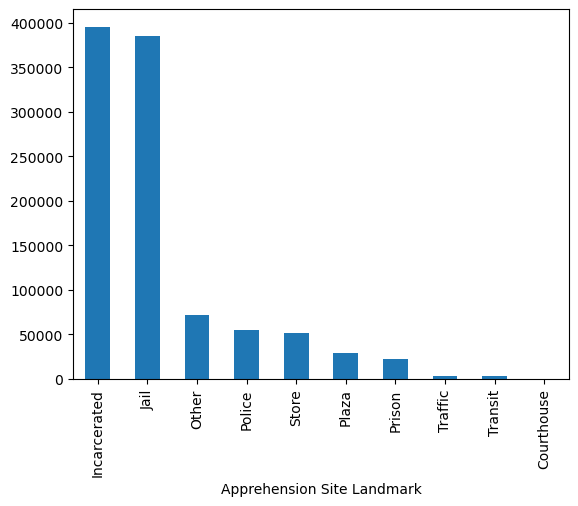

In [9]:
#drop general area because it's disproportionately high and largely useless for us
landmarks_country_alltime.drop("General Area").plot.bar();

## A quick job, but a functional look nonetheless.
#### This is far from perfect, as landmarks are highly inconsistently recorded.
<i> There are some surprising things in here: Courthouse arrests are vanishingly rare, as are traffic/transit stops when it comes to the actual ICE arrest (at least, when it's recorded with any specificity). Most arrests are made in jails or other local detention/carceral institutions, with comparatively nearly none made in State prisons or public areas. This gives further credence to the idea that stopping ICE in the short-term means <b> stopping municipal police & local carceral institutions </b></i>

That being said, if a person isn't in contact with the CJS already, arrests made at popular stores & plazas are a significant portion of this data. It seems to be the case that ICE relies heavily on earlier forms of incarceration, but when they act on their own, they arrest at public frequented spaces.

--

We may get a better look at what we can do, especially in the non-institutionalized cases, if we also consider:
# How are they making these arrests?
#### This will also give us a better look at the pre-incarcerated / ICE-arrested split

In [10]:
#input subset of overall df w/ apprehension method, output value counts of processed methods
def process_method(arr):
    arr_meth = arr["Apprehension Method"].dropna()
    
    #keyword matching. task forces are part of 287(g) program
    method = [
        ["Incarcera|ERO Reprocessed|Criminal Alien Program|Parole|to INS", "Seized From Incarceration"],
        ["Transport|boat|traffic|crewman", "Transportation Check"],
        ["Inspection|Worksite", "Inspections"],
        ["Patrol", "Patrols"],
        ["Arrest|287|Response Unit|Located|Task|Smuggling|Fugitive", "Targeted Arrest"]
    ]

    #replace them!
    for kv in method : arr_meth[arr_meth.str.contains(kv[0], case=False)] = kv[1]
        
    #pre-incarcerated
    return arr_meth.value_counts()

In [11]:
methods = process_method(arrests_original)

<AxesSubplot: xlabel='Apprehension Method'>

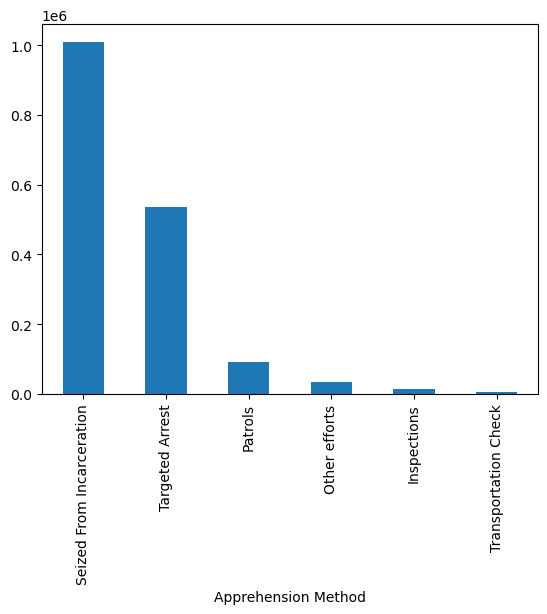

In [12]:
methods.plot.bar();

## Given that these are all percentages of the "whole" of arrests, we can also represent this as a pie chart!

<AxesSubplot: title={'center': 'Arrest Methods'}, ylabel='count'>

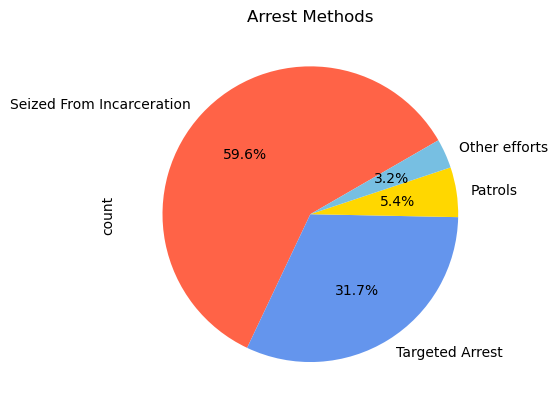

In [13]:
methods["Other efforts"] = methods[["Other efforts", "Inspections", "Transportation Check"]].sum()
methods = methods[0 : 4]
methods.plot.pie(autopct='%1.1f%%', colors=['tomato', 'cornflowerblue', 'gold', "#77BFE2"], startangle = 30, title = "Arrest Methods");

# <b>From this, we can draw some conclusions about direct action efforts</b>

One
---
<i>ICE is most active in the mornings, around 10:30am, and remains active between daylight hours. Communities should focus diversion and distraction efforts to the mid-morning moreso than the afternoon if resources such as people or time are scarce. </i>

Two
---
<i> The majority of ICE arrests are <b>already incarcerated</b> individuals in jails, correctional facilities, prisons, or who are on probation. Much less common, but still frequent, are arrests made in plazas, near shops, on main streets, or in various residential areas. Communities may seek to both focus on keeping people out of jalis or correctional facilities by not just alerting on ICE presence, but on police presence as well. Furthermore, areas that communities should focus for on-the-ground work are at plazas or near frequently used stores. </i>

Three
---
<i> While over half of ICE arrests are on already incarcerated individuals, just under a third are targeted arrests. These are arrests made through hunting individuals (listed as "located") or made by officers on the ground. ICE officers are most common (HSI & ERO), though under the 287(g) program municipal police can act as ICE agents in part, able to make arrests, detentions, and other specialized immigration-policing actions.
Communities may focus on intercepting not only ICE officers, who may be labeled HSI & ERO, but also local police departments who are partnered through the 287(g) program. Only 6 states disallow such agreements, and 10 total lack an agreement. 